# Student's Unpaired T-Test for Comparing Means

> Use Case: 
- Compare means of two independent groups to determine if there is a significant difference.
> Assumptions:
- Data is approximately normally distributed.
- Homogeneity of variances (variances are roughly equal).
- Observations are independent.
> Example Scenario:
- Investigating if there is a significant difference in the test scores of students who attended two different teaching methods.
> Null Hypothesis (H0):
- There is no significant difference in the means of the two groups.
> Alternative Hypothesis (H1):
- There is a significant difference in the means of the two groups.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import shapiro, levene
# since SciPy and statsmodels have the same named test (ttest_ind), I'll use this import convention instead
from scipy import stats


# !pip install statsmodels==0.12.2
from statsmodels.stats.power import TTestIndPower
# since SciPy and statsmodels have the same named test (ttest_ind), I'll use this import convention instead
from statsmodels.stats import weightstats

# !pip install pingouin==0.5.4
import pingouin as pg

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

In [15]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'slateblue'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

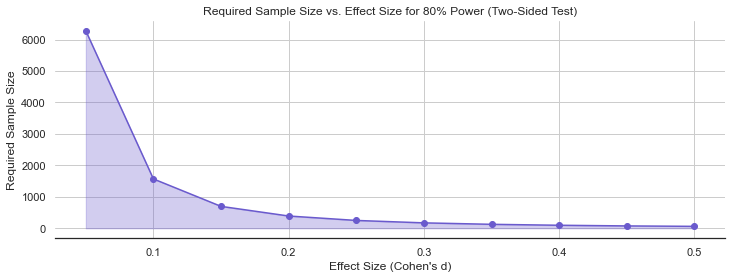

In [19]:
# Set the parameters for the power analysis
alpha = 0.05  # Significance level
desired_power = 0.8  # Desired statistical power

# Create an instance of the TTestIndPower class
power_analysis = TTestIndPower()

# Define the range of effect sizes to test
effect_sizes = np.linspace(0.05, 0.5, 10)  # Effect sizes from 0.1 to 1.0 in 10 increments

# Calculate the required sample size for each effect size
sample_sizes = []
for effect_size in effect_sizes:
    sample_size = power_analysis.solve_power(
        effect_size=effect_size, alpha=alpha, power=desired_power, alternative='two-sided'
    )
    sample_sizes.append(round(sample_size))  # Rounding to get an integer value

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 4))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Effect Size for 80% Power (Two-Sided Test)')
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Required Sample Size')
plt.grid(True)
plt.show()

In [23]:
# Set the parameters for the power analysis
effect_size = 0.1  # Cohen's d, the standardized effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired statistical power

# Create an instance of the TTestIndPower class
power_analysis = TTestIndPower()

# Calculate the required sample size per group
sample_size = int(np.ceil(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')))

# Print the result
print(f"Required sample size per group: {round(sample_size)}")

Required sample size per group: 1571


### Synthetic Data

In [24]:
# Generate synthetic data for t-test
group_a = np.random.normal(loc=50, scale=10, size=sample_size)
group_b = np.random.normal(loc=55, scale=10, size=sample_size)

# Create pandas DataFrame
t_test_data = pd.DataFrame({'Group A': group_a, 'Group B': group_b})
t_test_data

,Group A,Group B
0,42.272913,63.507207
1,57.948627,64.801175
2,53.142720,49.509221
3,36.737345,48.202219
4,64.172990,58.462136
...,...,...
1566,44.133497,58.028769
1567,45.334260,58.591852
1568,59.575787,63.230092
1569,26.476416,65.969006


### Assumptions

In [25]:
# Assumption validation for t-test
def validate_t_test_assumptions(data, alpha=0.05):
    # Shapiro-Wilk test for normality
    stat, p_value = shapiro(data)
    print(f'Shapiro-Wilk Test (Normality): Statistic={stat}, p-value={p_value}')

    # Interpretation based on p-value for normality
    if p_value < alpha:
        print(f'Reject the null hypothesis: \nData is not normally distributed.')
    else:
        print(f'Fail to reject the null hypothesis: \nData is approximately normally distributed.')

    # Levene's test for homogeneity of variances
    stat, p_value = levene(data['Group A'], data['Group B'])
    print(f'\nLevene\'s Test (Homogeneity of Variances): Statistic={stat}, p-value={p_value}')

    # Interpretation based on p-value for homogeneity of variances
    if p_value < alpha:
        print(f'Reject the null hypothesis: \nVariances are not homogeneous between Group A and Group B.')
    else:
        print(f'Fail to reject the null hypothesis: \nVariances are homogeneous between Group A and Group B.')

# Example usage for t-test data
validate_t_test_assumptions(t_test_data)

Shapiro-Wilk Test (Normality): Statistic=0.9996436176580087, p-value=0.8784932097048082
Fail to reject the null hypothesis: 
Data is approximately normally distributed.

Levene's Test (Homogeneity of Variances): Statistic=0.5990744177062632, p-value=0.4389896655538096
Fail to reject the null hypothesis: 
Variances are homogeneous between Group A and Group B.


### T-test (SciPy)

In [32]:
# Run t-test
def run_t_test(data, alpha=0.05):
    stat, p_value = stats.ttest_ind(data['Group A'], data['Group B'])
    print(f't-Test: Statistic={stat}, p-value={p_value}')

    # Interpretation based on p-value
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between Group A and Group B.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between Group A and Group B.')

# Example usage for t-test data
run_t_test(t_test_data)

t-Test: Statistic=-15.180733240885237, p-value=2.7717097128790485e-50

Reject the null hypothesis: 
There is a significant difference between Group A and Group B.


### T-test (statsmodels)

In [38]:
# Run t-test
def run_t_test(data, alpha=0.05):
    stat, p_value, dof = weightstats.ttest_ind(data['Group A'], data['Group B'])
    print(f't-Test: Statistic={stat})')
    print(f't-Test: p-value={p_value}')
    print(f't-Test: dof={dof}')

    # Interpretation based on p-value
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between Group A and Group B.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between Group A and Group B.')

# Example usage for t-test data
run_t_test(t_test_data)

t-Test: Statistic=-15.180733240885198)
t-Test: p-value=2.771709712880512e-50
t-Test: dof=3140.0

Reject the null hypothesis: 
There is a significant difference between Group A and Group B.


### T-test (pingouin)

In [40]:
# T-test
pg.ttest(t_test_data['Group A'], t_test_data['Group B'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-15.180733,3140,two-sided,2.771710e-50,"[-5.98, -4.61]",0.541651,5.146e+46,1.0


### 95% Confidence Interval

In [44]:
# Calculate the means of each group
mean_a = t_test_data['Group A'].mean()
mean_b = t_test_data['Group B'].mean()

# Calculate the standard deviations of each group
std_a = t_test_data['Group A'].std()
std_b = t_test_data['Group B'].std()

# Calculate the sample sizes
n_a = len(t_test_data['Group A'])
n_b = len(t_test_data['Group B'])

# Calculate the standard error for the difference in means
se_diff = np.sqrt(std_a**2 / n_a + std_b**2 / n_b)

# Calculate the difference in means
diff_means = mean_a - mean_b

# Get the degrees of freedom using the Welch-Satterthwaite equation
degrees_of_freedom = (std_a**2 / n_a + std_b**2 / n_b)**2 / (
    ((std_a**2 / n_a)**2) / (n_a - 1) + ((std_b**2 / n_b)**2) / (n_b - 1))

# Critical t-value for a 95% confidence interval
critical_t = stats.t.ppf(0.975, df=degrees_of_freedom)  # two-sided

# Calculate the margin of error
margin_of_error = critical_t * se_diff

# Calculate the 95% confidence interval
lower_bound = diff_means - margin_of_error
upper_bound = diff_means + margin_of_error

# Print results
print(f"Difference in Means: {diff_means}")
print(f"95% Confidence Interval of the Difference in Means: [{lower_bound}, {upper_bound}]")


Difference in Means: -5.297274314745387
95% Confidence Interval of the Difference in Means: [-5.981462173464104, -4.61308645602667]


### Effect Size

In [51]:
# Calculate means
mean_a = np.mean(group_a)
mean_b = np.mean(group_b)

# Calculate standard deviations
std_a = np.std(group_a, ddof=1)  # Using sample standard deviation
std_b = np.std(group_b, ddof=1)

# Calculate sample sizes
n_a = len(group_a)
n_b = len(group_b)

# Calculate pooled standard deviation
s_pooled = np.sqrt(((n_a - 1) * std_a**2 + (n_b - 1) * std_b**2) / (n_a + n_b - 2))

# Calculate Cohen's d
d = (mean_b - mean_a) / s_pooled

print(f"Cohen's d Effect Size: {d} standard deviations")
print("\n")


if d >= 2:
    print("There is a huge difference between the two groups.")
elif d >= 1.2:
    print("There is a very large difference between the two groups.")
elif d >= 0.8:
    print("There is a large difference between the two groups.")
elif d >= 0.5:
    print("There is a moderate difference between the two groups.")
elif d >= 0.2:
    print("There is a small difference between the two groups.")
elif d >= 0.01:
    print("There is a very small difference between the two groups.")
else:
    print("There is no difference between the two groups.")


Cohen's d Effect Size: 0.4623242799496727 standard deviations


There is a small difference between the two groups.


### Visualization

In [11]:
# Count everything up
total_count = t_test_data.size
group_a_count = t_test_data['Group A'].count()
group_b_count = t_test_data['Group B'].count()
group_a_mean = t_test_data['Group A'].mean()
group_b_mean = t_test_data['Group B'].mean()
group_a_var= t_test_data['Group A'].var()
group_b_var = t_test_data['Group B'].var()
group_a_std= t_test_data['Group A'].std()
group_b_std = t_test_data['Group B'].std()

In [12]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Mean Test Score': [group_a_mean, group_b_mean],
    'Variance': [group_a_var, group_b_var],
    'Standard Deviation': [group_a_std, group_b_std],
}, index=[0, 1])
plot_data

,Test Group,Total,Mean Test Score,Variance,Standard Deviation
0,Group A,100,48.961535,82.476989,9.081684
1,Group B,100,55.223046,90.948450,9.536690


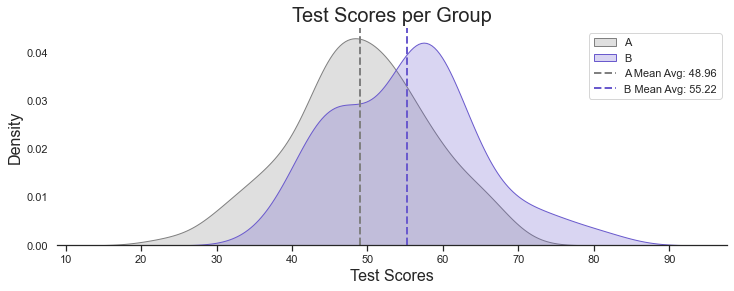

In [13]:
# Compare distributions of means between the two groups
plt.figure(figsize=(12, 4))
sns.kdeplot(t_test_data['Group A'], label='A', fill = True, color = 'grey' , clip=(0, 100))
sns.kdeplot(t_test_data['Group B'], label='B', fill = True, color = color, clip=(0, 100))
mean_group_a = t_test_data['Group A'].mean()
mean_group_b = t_test_data['Group B'].mean()
plt.axvline(mean_group_a, color='grey', linestyle='dashed', linewidth=2, label=f'A Mean Avg: {mean_group_a:.2f}')
plt.axvline(mean_group_b, color=color, linestyle='dashed', linewidth=2, label=f'B Mean Avg: {mean_group_b:.2f}')
plt.title('Test Scores per Group', fontsize = 20)
plt.xlabel('Test Scores', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.legend()
plt.show()